# Urban Greenspace and Asthma Prevalence

This project examines the link between vegitation cover (using average NDVI as a measurement of vegatation health) and human health. In this notebooke I will calucalte patch, edge, and fragmentation statistics about urban greenspace in Washington D.C. These statistics should be reflective of the connectivity and spread of urban greenspace, which are important for ecosystem function and access. I then use a inear model to identify statistically significant correlations between the distribution of greenspace and health data compiled by the US Center for Disease Control.

## Using 'Big Data' in the Form of Census Tracts

For this project, I split up the green space (NDVI) data by census tract, because this matches the human health data from the CDC. Because I need to know more about the structure of green space within each tract, I need higher resolution data, so I will use National Agricultural Imagery Program (NAIP) data, which is taken for the continental US every few years at 1m resolution. The main purpose of the NAIP data is, as the name suggests, agriculture. However, it’s also a great source for urban areas where lots is happening on a very small scale.

# Setting up the Analysis

In [81]:
# Import libraries
import pandas as pd
import rioxarray as rxr # Work with geospatial raster data
import geopandas as gpd
import pathlib
import os
import hvplot.pandas
import geoviews as gv
import cartopy.crs as ccrs
gv.extension('bokeh')  # Activates GeoViews with the Bokeh backend

# For the NDVI Data
import re # Extract metadata from file names
import zipfile # Work with zip files
from io import BytesIO # Stream binary (zip) files
import numpy as np # Unpack bit-wise Fmask
import requests # Request data over HTTP
import pystac_client
import rioxarray.merge as rxrmerge
import shapely
import xarray as xr
import glob
from cartopy import crs as ccrs
from scipy.ndimage import convolve
from sklearn.model_selection import KFold
from scipy.ndimage import label
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [61]:
# Create Reproducable File Paths
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    # Earth analytics data directory
    'earth-analytics',
    'data',
    # Project directory
    'big-data',
)
os.makedirs(data_dir, exist_ok=True)

In [62]:
# Prevent GDAL from quitting due to momentary disruptions
os.environ["GDAL_HTTP_MAX_RETRY"] = "5"
os.environ["GDAL_HTTP_RETRY_DELAY"] = "1"

## STEP 2: Create a site map

Use the Center for Disease Control (CDC) Places dataset for human health data to compare with vegetation. CDC Places also provides
some modified census tracts, clipped to the city boundary, to go along with the health data. Start by downloading the matching geographic
data, and then select the City of Denver D.C.

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

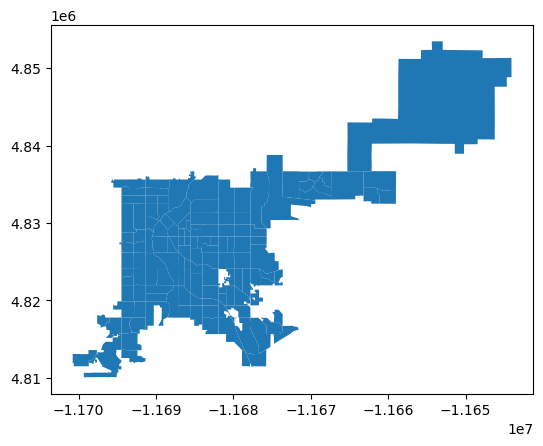

In [70]:
#Create a file path for your CDC Tract Data

cdc_data_dir = os.path.join(data_dir, 'cdc_data_2')
os.makedirs(cdc_data_dir, exist_ok=True)
cdc_data_path = os.path.join(cdc_data_dir, '*.shp')

# Define info for CDC download, and only download cdc data once
if not os.path.exists(cdc_data_path):
    cdc_data_url = ('https://data.cdc.gov/download/x7zy-2xmx/application%2Fzip')
    cdc_data_gdf = gpd.read_file(cdc_data_url)
    denver_gdf = cdc_data_gdf[cdc_data_gdf.PlaceName=='Denver']
    denver_gdf.to_file(cdc_data_path, index=False)

# Load in cdc data
denver_gdf = gpd.read_file(cdc_data_path)

# Check the data - site plot 
denver_gdf.plot()

(
    denver_gdf
    .to_crs(ccrs.Mercator())
    .hvplot(
        line_color='red', fill_color=None,
        crs=ccrs.Mercator(), tiles='EsriImagery',
        frame_width=600
    )
)

# City of Denver Data Description

Data is drawn from the Center for Disease Control PLACES: Local Data for Better Health data set. The Places Dataset estimates chronic disease and other health-related measures at various geographic levels of the United States using a small area estimation methodology. Data are derived from Behavioral Risk Factors Surveillance System data, Census population data, and American Community Survey data. There are a total of 40 measures genereated in ghe 2024 release. For more information see the CDC Places website.

For this analysis, I will be using data from the city level - specifically the city of Denver. 

For information on how to access this data via the CDC portal, you can follow this tutorial. https://www.cdc.gov/places/tools/explore-places-data-portal.html

Reference: https://www.cdc.gov/places/methodology/index.html


You can obtain urls for the U.S. Census Tract shapefiles from [the TIGER
service](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html).
You’ll notice that these URLs use the state FIPS, which you can get by
looking it up
(e.g. [here](https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm),
or by installing and using the `us` package.

<Axes: >

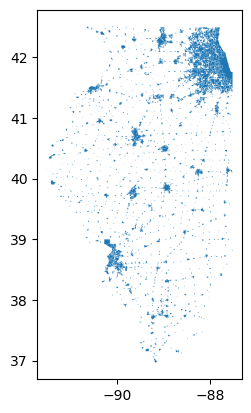

In [82]:
# Define info for big data download (Colorado)
census_data_1_url=("https://www2.census.gov/geo/tiger/TIGER2024/PLACE/tl_2024_17_place.zip"
)

census_data_1_dir = os.path.join(data_dir, 'census_data_1')
os.makedirs(census_data_1_dir, exist_ok=True)
census_data_1_path = os.path.join(census_data_1_dir, '*.shp') # Spatial Join 

# Only download the census tracts once
if not os.path.exists(census_data_1_path):
    census_data_1_gdf = gpd.read_file(census_data_1_url)
    census_data_1_gdf.to_file(census_data_1_path)
    den_census_gdf = census_data_1_gdf[census_data_1_gdf.NAME=='Denver']
    den_census_gdf.to_file(census_data_1_gdf, index=False)
    

# Load in census tract data
census_data_1_gdf = gpd.read_file(census_data_1_path)

# Check the data - site plot - Census tracts with satellite imagery in the background
census_data_1_gdf.plot()


## STEP 3 - Access Asthma and Urban Greenspaces Data

In [75]:
# Set up a path for the asthma data
asthma_path = os.path.join(data_dir, 'asthma.csv')

# Download asthma data (only once)
if not os.path.exists(cdc_path):
    asthma_url = (
        "https://data.cdc.gov/resource/cwsq-ngmh.csv"
        "?year=2022"
        "&stateabbr=CO"
        "&countyname=Denver"
        "&measureid=CASTHMA"
        "&$limit=1500"
    )
    asthma_df = (
        pd.read_csv(asthma_url)
        .rename(columns={
            'data_value': 'asthma',
            'low_confidence_limit': 'asthma_ci_low',
            'high_confidence_limit': 'asthma_ci_high',
            'locationname': 'tract'})
        [[
            'year', 'tract', 
            'asthma', 'asthma_ci_low', 'asthma_ci_high', 'data_value_unit',
            'totalpopulation', 'totalpop18plus'
        ]]
    )
    asthma_df.to_csv(asthma_path, index=False)

# Load in asthma data
asthma_df = pd.read_csv(asthma_path)

# Preview asthma data
asthma_df

,year,tract,asthma,asthma_ci_low,asthma_ci_high,data_value_unit,totalpopulation,totalpop18plus
0,2022,8031006902,10.9,9.7,12.1,%,3638,3032
1,2022,8031006903,10.1,9.0,11.2,%,2475,2105
2,2022,8031000301,9.4,8.3,10.4,%,5779,4885
3,2022,8031003102,11.3,10.1,12.5,%,4082,3787
4,2022,8031008391,10.6,9.4,11.7,%,7855,5543
...,...,...,...,...,...,...,...,...
171,2022,8031004308,10.3,9.2,11.5,%,4132,3731
172,2022,8031006812,10.1,9.0,11.2,%,3932,3476
173,2022,8031004306,9.9,8.8,11.0,%,6092,4686
174,2022,8031004111,9.9,8.8,11.0,%,6848,4500


### Join health data with census tract boundaries

In [87]:
# Change tract identifier datatype for merging
denver_gdf.tract2010 = denver_gdf.tract2010.astype('int64')

# Merge census data with geometry
den_merged_gdf = (
    denver_gdf
    .merge(asthma_df, left_on='tract2010', right_on='tract', how='inner')
)

# Plot asthma data as chloropleth
(
    gv.tile_sources.EsriImagery
    * 
    gv.Polygons(
        den_merged_gdf.to_crs(ccrs.Mercator()),
        vdims=['asthma', 'tract2010'],
        crs=ccrs.Mercator()
    ).opts(color='asthma', colorbar=True, tools=['hover'])
).opts(width=600, height=600, xaxis=None, yaxis=None)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (asthma,tract2010)

# CDC ASTHMA PLACES DESCRIPTION AND CITATION
## Reflect and Respond

### Get Data URLs

NAIP data are freely available through the Microsoft Planetary Computer
SpatioTemporal Access Catalog (STAC).

In [88]:
# Connect to the planetary computer catalog
e84_catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
e84_catalog.title

'Microsoft Planetary Computer STAC API'

In [89]:
# Use a loop and for each Census track search for the approrpiate data. 
# Convert geometry to lat/lon for STAC
den_merged_latlon_gdf = den_merged_gdf.to_crs(4326)

# Define a path to save NDVI stats
den_ndvi_stats_path = os.path.join(data_dir, 'denver-ndvi-stats.csv')

# Check for existing data - do not access duplicate tracts
downloaded_tracts = []
if os.path.exists(den_ndvi_stats_path):
    den_ndvi_stats_df = pd.read_csv(den_ndvi_stats_path)
    downloaded_tracts = den_ndvi_stats_df.tract.values
else:
    print('No census tracts downloaded so far')
    
# Loop through each census tract
den_scene_dfs = []
for i, den_tract_values in tqdm(den_merged_latlon_gdf.iterrows()):
    den_tract = den_tract_values.tract2010
    # Check if statistics are already downloaded for this tract
    if not (tract in downloaded_tracts):
        # Retry up to 5 times in case of a momentary disruption
        i = 0
        retry_limit = 5
        while i < retry_limit:
            # Try accessing the STAC
            try:
                # Search for tiles
                den_naip_search = e84_catalog.search(
                    collections=["naip"],
                    intersects=shapely.to_geojson(den_tract_values.geometry),
                    datetime="2021"
                )
                
                # Build dataframe with tracts and tile urls
                den_scene_dfs.append(pd.DataFrame(dict(
                    tract=tract,
                    date=[pd.to_datetime(scene.datetime).date() 
                          for scene in den_naip_search.items()],
                    den_rgbir_href=[scene.assets['image'].href for scene in den_naip_search.items()],
                )))
                
                break
            # Try again in case of an APIError
            except pystac_client.exceptions.APIError:
                print(
                    f'Could not connect with STAC server. '
                    f'Retrying tract {tract}...')
                time.sleep(2)
                i += 1
                continue
    
# Concatenate the url dataframes
if den_scene_dfs:
    den_scene_df = pd.concat(den_scene_dfs).reset_index(drop=True)
else:
    den_scene_df = None

# Preview the URL DataFrame
den_scene_df

No census tracts downloaded so far


0it [00:00, ?it/s]

,tract,date,den_rgbir_href
0,8031015700,2021-07-28,https://naipeuwest.blob.core.windows.net/naip/...
1,8031015700,2021-07-28,https://naipeuwest.blob.core.windows.net/naip/...
2,8031015700,2021-07-28,https://naipeuwest.blob.core.windows.net/naip/...
3,8031015700,2021-07-28,https://naipeuwest.blob.core.windows.net/naip/...
4,8031015700,2021-07-28,https://naipeuwest.blob.core.windows.net/naip/...
...,...,...,...
180,8031015700,2021-07-28,https://naipeuwest.blob.core.windows.net/naip/...
181,8031015700,2021-07-28,https://naipeuwest.blob.core.windows.net/naip/...
182,8031015700,2021-07-28,https://naipeuwest.blob.core.windows.net/naip/...
183,8031015700,2021-07-28,https://naipeuwest.blob.core.windows.net/naip/...


In [90]:
# Define the directory
hls_1_dir = os.path.join(data_dir, 'hls_1')
os.makedirs(hls_1_dir, exist_ok=True)

hls_1_url = (
    "https://github.com/cu-esiil-edu/esiil-learning-portal/releases"
    "/download/data-release/redlining-foundations-data.zip"
)

if not glob.glob(os.path.join(hls_1_dir, '*.tif')):
    # Download sample raster data
    hls_1_response = requests.get(hls_1_url)

    # Save the raster data (uncompressed)
    with zipfile.ZipFile(BytesIO(hls_1_response.content)) as hls_1_zip:
        hls_1_zip.extractall(hls_1_dir)


### Compute NDVI Statistics

In [94]:
# Skip this step if data are already downloaded 
if not den_scene_df is None:
    # Get an example tract
    tract = denver_gdf.loc[0].tract2010
    den_scene_gdf = den_scene_df[den_scene_df.tract==tract]

    # Loop through all images for tract
    den_tile_das = []
    for _, href_s in den_scene_gdf.iterrows():
        # Open vsi connection to data
        den_tile_da = rxr.open_rasterio(
            href_s.rgbir_href, masked=True).squeeze()
        
        # Crop data to the bounding box of the census tract
        den_boundary = (
            den_merged_gdf
            .set_index('tract2010')
            .loc[[tract]]
            .to_crs(den_tile_da.rio.crs)
            .geometry
        )
        den_crop_da = den_tile_da.rio.clip_box(
            *boundary.envelope.total_bounds,
            auto_expand=True)

        # Clip data to the boundary of the census tract
        den_clip_da = den_crop_da.rio.clip(boundary, all_touched=True)
            
        # Compute NDVI
        den_ndvi_da = (
            (den_clip_da.sel(band=4) - den_clip_da.sel(band=1)) 
            / (den_clip_da.sel(band=4) + den_clip_da.sel(band=1))
        )

        # Accumulate result
        den_tile_das.append(den_ndvi_da)

    # Merge data
    den_scene_da = rxrmerge.merge_arrays(den_tile_das)

    # Mask vegetation
    den_veg_mask = (den_scene_da>.3)

    # Calculate mean patch size
    labeled_patches, num_patches = label(den_veg_mask)
    
    # Count patch pixels, ignoring background at patch 0
    patch_sizes = np.bincount(labeled_patches.ravel())[1:]
    mean_patch_size = patch_sizes.mean()

    # Calculate edge density
    kernel = np.array([
        [1, 1, 1], 
        [1, -8, 1], 
        [1, 1, 1]])
    edges = convolve(den_veg_mask, kernel, mode='constant')
    edge_density = np.sum(edges != 0) / veg_mask.size


IndexError: list index out of range

### Repeat for all tracts

Using a loop, for each Census Tract:</p>
Using a loop, for each data URL:</p>
Compute NDVI for the tract
Merge the NDVI rasters
Accumulate the statistics in a file for later
